## Classification: SVM, Trees and Forests
Lukas Wenzl

Sources:
- Book, code from AstroML

- Jake Vanderplas (University of Washington) -- one of the primary code developers of scikit-learn and astroML. 
I draw a lot from https://github.com/jakevdp/ESAC-stats-2014, 
but you can find a lot more from him: https://github.com/jakevdp/.



In [1]:
#some imports (i tried to put the specific ones in sktlearn where they are actually used in the code)

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


bubble_size=50

#big plots for presentation; comment all out for normal use
#plt.style.use('seaborn-talk')
#import matplotlib as mpl
#mpl.rcParams['xtick.labelsize'] = 25
#mpl.rcParams['ytick.labelsize'] = 25
#mpl.rcParams['axes.titlesize'] = 25
#mpl.rcParams['axes.labelsize'] = 25
#mpl.rcParams['lines.color'] = 'r'
#bubble_size=150

## Motivating Support Vector Machines

Support Vector Machines (SVMs) are a powerful supervised learning algorithm used for **classification** or for **regression**. SVMs are a **discriminative** classifier: that is, they draw a boundary between clusters of data.

Let's show a quick example of support vector classification. First, we need to create a dataset:

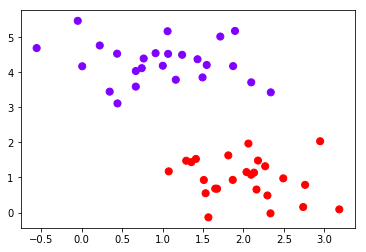

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=bubble_size, cmap='rainbow');

A discriminative classifier attempts to draw a line between the two sets of data. Immediately we see a problem: such a line is ill-posed! For example, we could come up with several possibilities which perfectly discriminate between the classes in this example:

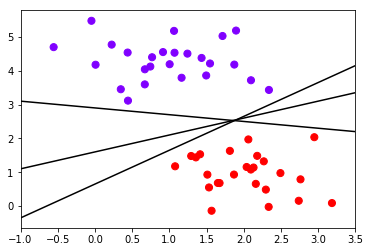

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=bubble_size, cmap='rainbow')

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three *very* different separaters which perfectly discriminate between these samples. Depending on which you choose, a new data point will be classified almost entirely differently!

How can we improve on this?

### Support Vector Machines: Maximizing the *Margin*

Support vector machines are one way to address this.
What support vector machined do is to not only draw a line, but consider a *region* about the line of some given width.  Here's an example of what it might look like:

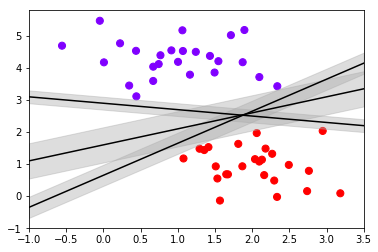

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=bubble_size, cmap='rainbow')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

Notice here that if we want to maximize this width, the middle fit is clearly the best.
This is the intuition of **support vector machines**, which optimize a linear discriminant model in conjunction with a **margin** representing the perpendicular distance between the datasets.

#### Fitting a Support Vector Machine

Now we'll fit a Support Vector Machine Classifier to these points. We first use the alg as a black box and afterwards will discuss the maths behind it:

In [5]:
from sklearn.svm import SVC # "Support Vector Classifier"
clf = SVC(kernel='linear')
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

To better visualize what's happening here, let's create a quick convenience function that will plot the SVM decision boundaries for us:

In [6]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 300)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 300)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    #for i, xi in enumerate(x): for some reason not working, i defined Z instead, workes better
    #   for j, yj in enumerate(y):
    #       P[i, j] = clf.decision_function(np.c_[xi, yj])
    #P = P.reshape(-1,1)
    Z = clf.predict(np.c_[X.ravel(), Y.ravel()])
    Z = Z.reshape(X.shape)
    return ax.contour(X, Y, Z, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])


The points that minimize the margin are called *support vectors* (giving the alg its name).
In scikit-learn, these are stored in the ``support_vectors_`` attribute of the classifier, here we circle them in the plot:

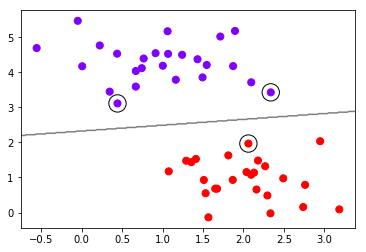

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=bubble_size, cmap='rainbow')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, facecolors='none', edgecolors='black');

# How do we find that hyperplane?


given points $(x_i, y_i)$, with $y_i \in \{-1,1\}$ indicating the class of the point.

and the hyperplane we want to find denoted by $\beta_0, \beta$ which fullfills $\beta_0 + \beta^T x = 0$


# first we assume they are linearely seperable:

we want to maximize the margin m between the two classes:

$ \forall i: m\leq \frac{1}{||\beta||} y_i (\beta_0 + \beta^T x_i) $



an 2D example for illustration of the "margin":
let the hyperplane be $x-y=0$
then the point (2,0) has margin $m= \frac{1}{\sqrt{2}} y_1 (2-0) = \sqrt{2}$
![example_svm.png](images/example_svm.png)

The length $||\beta||$ is a free parameter in our formula, therefore we can arbitrarely set it to $||\beta|| = 1/m$ (if you think about this for a while you realize this means normalizing the distance from the support vector to the hyperplane to 1), which allows us to instead minimize $||\beta||$ with the constraint

$\forall i: 1 \leq y_i (\beta_0 + \beta^T x_i) $

This is quadratic objective function with linear constraints, an optimisation problem that is well studied. We get that the optimal values are: (not explained in the book, i will just assume this here)

$$\beta_j = \sum_1^N \alpha_i y_i x_{ij}$$

where $\alpha$ is the vector that maximizes

$$\sum_i^N \alpha_i - \frac{1}{2} \sum_i^N \sum_{j}^N \alpha_i \alpha_{j} y_i y_{j} \; x_i * x_j $$ (vector product)

subject to $\alpha_i \geq 0$ and $\sum_i \alpha_i y_i = 0$

We then classify simply by testing if a point is above or below the hyperplane:

$$y_{prediction} (x) = \text{sign}(\beta_0 + \sum_i^N \alpha_i y_i \; x*x_i)$$


# but what to to when they are not linearely seperable?

What we need to do is to accept some errors for our minimization problem: For that we introduce a 'slack' $\xi_i$ variable with $$\xi_i \geq 0; \sum_i \xi_i \leq C$$

For most points the slack should be 0, but for the few outliers the variable saves our function. For that we modify our optimization problem as follows:

minimze $||\beta||$ subjet to $\forall i: y_i (\beta_0 + \beta^T x_i) \geq 1 - \xi_i$, illustrated in the image below:
![example2_svm.png](images/example2_svm.png)

C becomes a tuning parameter for the SVM.


## Example with the RR Lyrae Data

@pickle_results: using precomputed results from 'SVM_rrlyrae.pkl'
completeness [ 0.99270073  1.          1.          1.        ]
contamination [ 0.90014684  0.85347594  0.85347594  0.85471898]


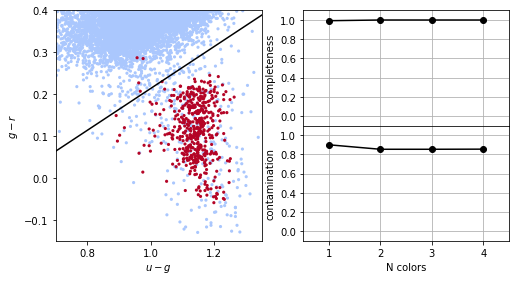

In [10]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.svm import SVC
from astroML.decorators import pickle_results
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results

# SVM takes several minutes to run, and is order[N^2]
#  truncating the dataset can be useful for experimentation.
#X = X[::5]
#y = y[::5]

(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# Fit SVM
Ncolors = np.arange(1, X.shape[1] + 1)

@pickle_results('SVM_rrlyrae.pkl') #saves result to recompute faster, delete with import os; os.remove('SVM_rrlyrae.pkl') 
def compute_SVM(Ncolors):
    classifiers = []
    predictions = []

    for nc in Ncolors:
        # perform support vector classification
        clf = SVC(kernel='linear', class_weight='balanced')#'auto') auto from astroML code not available anymore, used balanced instead
       
        #here we apply the discussed alg to our training set to obtain the best hyperplane, fist time we only
        #use one color, so hyperplane is a point on a line (i think), then we use u-g and g-r, and then even more colors.
        clf.fit(X_train[:, :nc], y_train)
        
        #here we we make predictions about the training set, using our hyperplane model
        y_pred = clf.predict(X_test[:, :nc])

        classifiers.append(clf)
        predictions.append(y_pred)

    return classifiers, predictions

classifiers, predictions = compute_SVM(Ncolors)

completeness, contamination = completeness_contamination(predictions, y_test)

print "completeness", completeness
print "contamination", contamination

#------------------------------------------------------------
# compute the decision boundary
clf = classifiers[1]
w = clf.coef_[0]
a = -w[0] / w[1]
yy = np.linspace(-0.1, 0.4)
xx = a * yy - clf.intercept_[0] / w[1]

#----------------------------------------------------------------------
# plot the results
fig = plt.figure() #figsize=(5, 2.5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.15, right=1.2, wspace=0.2) ##changed fig size a bit

# left plot: data and decision boundary
ax = fig.add_subplot(121)
ax.plot(xx, yy, '-k')
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=10, lw=0, cmap='coolwarm', zorder=2)
im.set_clim(-0.5, 1)

ax.set_xlim(0.7, 1.35)
ax.set_ylim(-0.15, 0.4)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

We see that SVM show a high completeness compared to the other methods discussed before: it is **not swayed by the fact that
the background sources outnumber the RR Lyrae stars** by a factor of ∼200 to 1: it
simply determines the best boundary between the small RR Lyrae clump and the large
background clump. This completeness, however, comes at the cost of a relatively
large contamination level.

refresher:

$$ \text{completeness} = \dfrac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$


$$ \text{contamination} = \dfrac{\text{false positives}}{\text{true positives} + \text{false negatives}}$$

## Non linear SVM's
The idea of kernelization is a simple but powerful way to take a support vector
machine and make it nonlinear—in the dual formulation, one simply replaces each
occurrence of $ x_i * x_j $ (vector product) with a kernel function $K (x_i, x_j)$ with certain properties which
allow one to think of the SVM as operating in a higher-dimensional space. One such
kernel is the Gaussian kernel (called rbf for radial basis function in scikit learn):

$$K(x_i, x_j) = e^{-\gamma ||x_i - x_j||^2}$$

where γ is a parameter to be learned via cross-validation.

First let us illustrate the concept on a simple example: let's consider a set of data that is not linearly seperable, but is visually easily seperable. The linear model fails:

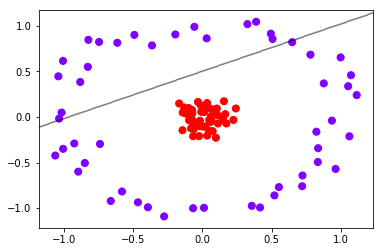

In [11]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=bubble_size, cmap='rainbow')
plot_svc_decision_function(clf);

We now introduce a radial basis function. r gets big close to (0,0) and tends to zero far away.
$$r = e^{-(x^2 + y^2)}$$

In [12]:
r = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))

If we plot this along with our data, we can see the effect of it:

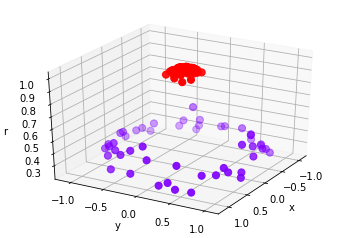

In [15]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=bubble_size, cmap='rainbow')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

plot_3D ()

We can see that with this additional dimension, the data becomes trivially linearly separable!
This is a relatively simple kernel; sklearn SVM has the gaussian kernel implemented.


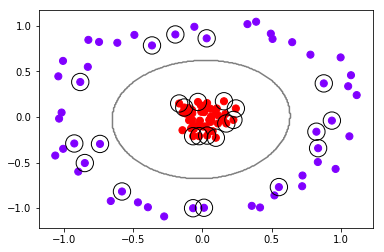

In [16]:
clf = SVC(kernel='rbf')
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=bubble_size, cmap='rainbow')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, facecolors='none', edgecolors='black');

We can also apply this to our RR Lyrae dataset:

@pickle_results: using precomputed results from 'kernelSVM_rrlyrae.pkl'
completeness [ 1.  1.  1.  1.]
contamination [ 0.90108303  0.83901293  0.83573141  0.81561238]


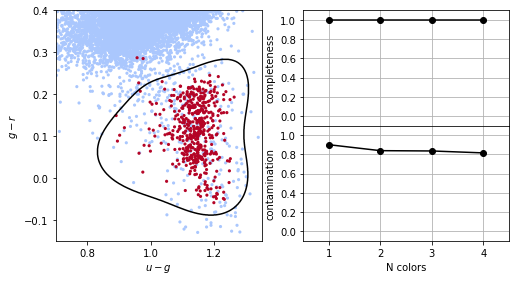

In [17]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.svm import SVC
from sklearn import metrics

from astroML.datasets import fetch_rrlyrae_mags
from astroML.decorators import pickle_results
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # re-order the colors for better 1-color results

# SVM takes several minutes to run, and is order[N^2]
#  truncating the dataset can be useful for experimentation.
#X = X[::5]
#y = y[::5]

(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# Fit Kernel SVM
Ncolors = np.arange(1, X.shape[1] + 1)


@pickle_results('kernelSVM_rrlyrae.pkl')
def compute_SVM(Ncolors):
    classifiers = []
    predictions = []

    for nc in Ncolors:
        # perform support vector classification
        clf = SVC(kernel='rbf', gamma=20.0, class_weight='balanced') # class_weight='auto')
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers.append(clf)
        predictions.append(y_pred)

    return classifiers, predictions

classifiers, predictions = compute_SVM(Ncolors)

completeness, contamination = completeness_contamination(predictions, y_test)

print "completeness", completeness
print "contamination", contamination

#------------------------------------------------------------
# compute the decision boundary
clf = classifiers[1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 1001),
                     np.linspace(ylim[0], ylim[1], 1001))

Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)

# smooth the boundary
from scipy.ndimage import gaussian_filter
Z = gaussian_filter(Z, 2)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure()
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.15, right=1.2, wspace=0.2) #changed fig size a bit

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=10, lw=0, cmap='coolwarm', zorder=2)  #plt.cm.binary
im.set_clim(-0.5, 1)


ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

the code is the same as before, just changed the kernel from "linear" to "rbf"
![kernelSVM_rrlyrae__plot.png](images/kernelSVM_rrlyrae__plot.png)

This nonlinear classification
improves over the linear version only slightly. For this particular data set, the
contamination is not driven by nonlinear effects.

Side note on **scaling**: Sklearn's implementation generally runs in $O(n^2)$, which is very time intensive for big datasets. If it is expected to yield similar results it is often better to use the linear kernel. For that case Sklearn has a special implementation called LinearSVM which uses a few neat tricks to bring the run time down significantly by approximating a bit.

## Decision Trees

Idea: we could classify our data by (axis aligned) decision boundaries. First, we split parallel to the y-axis, then we split the remaining cells parallel to the x-axis. At the end we determine for each cell elements of which class it contains (mainly). This way we can
classify this simple dataset with 2 classes.

![illustration_tree.png](images/illustration_tree.png)

This is what we generally call a decision tree. This concept is very general and powerfull. Sklearn has a version of this implemented and it uses the following idea to decide on the decision boundaries:

We define the **entropy** of the System (futher reading: gibbs entropy, statistical mechanics):

$$E(x) = - \sum_i p_i \, \text{ln} \, p_i$$

When the Entropy is high, we cannot say much about test data we get, there are many claims about the classification that are equally likely. So, we want to decrease the entropy with every step. (best case at the end every not has only elements of one class then E(x) =0 ). We quantify this as the **Information Gain IG**, the change in Entropy per step:

$$IG(x|x_i) = E(x) -  \frac{N_{left}}{N} E(x_{left}) - \frac{N_{right}}{N} E(x_{right})$$

Where $x_{left}$ are the elements in the left subtree, $N_{left}$ their number and the same for the right subtree.
Since this is in general a very hard problem, we simplify it to a one dimensional problem: We find the optimal value s to split along each axis and choose the one with the most information gain:

$$IG(x|s) = E(s) - arg\, max_s ( \frac{N(x|x \leq s)}{N} E(x,x \leq s) +  \frac{N(x|x \geq s)}{N} E(x,x \geq s))$$

other options (for further reading): 
- **Gini coefficient**

The Gini coefficient estimates the probability
that a source would be incorrectly classified if it was chosen at random from a data
set and the label was selected randomly based on the distribution of classifications
within the data set. So basically it **says how good our classification is** at the moment, high numbers mean that we have a high false pos and neg rate.

$$G= \sum_i^k p_i (1-p_i)$$

$p_i$ is the probability of finding a point with class i within a data set.


- **Misclassification Error**, MC

fractional probability that a point selected at
random will be misclassified 

$$MC = 1- max_i(p_i) $$


Deciscion tree for RR Lyrae Data:

![fig_rrlyrae_treevis_1.png](images/fig_rrlyrae_treevis_1.png)

implementation, again the same code
just replace the classifier:

from sklearn.tree import DecisionTreeClassifier #must be added in the beginning;
clf = DecisionTreeClassifier(random_state=0, max_depth=12, 
                                     criterion='entropy') #must be added in the loop; and remove the smothing funtion (gaussian filter)
                                     
We get:
![fig_rrlyrae_decisiontree_3.png](images/fig_rrlyrae_decisiontree_4.png)

## The Problem of overfitting

For a depth of 12 we get already get $2^{12} = 4096$ nodes. This way it happens very easily that we overfit the data. So for a decision tree we want to use a rather small depth, but also not too small. Common criteria for stopping are:

- when a node contains only one class of object
- when a split does not improve the information gain or reduce the misclassifications
- when the number of points per node reaches a predefined value (to be safe)

We can also use the cross-validation techniques introduced in previous chapters. 

But there is another way:

**We overfit on purpose**. The idea here is that after some depth the new structure we find just represents the noise. If we know create many trees with slightly different noises (different subsets of data) and average over them they average out. What remains is the max information that we can extract from the data. 

## Random Forests
We average over many decision trees:

example: we create two trees 1 and 2 and 2 classes. Each gives us a function $f_i(\text{x})$ that gives us the prob that an input x is in class 1 given tree i. So, the averaged probability is (here k=2):

$$f(x) = \frac{1}{k} \sum_i^k f_i(x)$$

That is already the general formula for getting the average. In our alg the samples i (**bootstrap samples**) are chosen at random the full dataset.

We also speed up our alg a bit. We now only choose m (often $=\sqrt{k}$) features (at random at each level) for which we test the information gain. This reduces running time and according to the book also addresses the fact that axis-aligned partitioning of the data does not accurately reflect the
potentially correlated and/or nonlinear decision boundaries that exist within data
sets. 

## Simple Example Random Forests

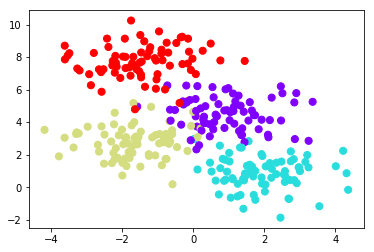

In [18]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=bubble_size, cmap='rainbow');

Example of overfitted trees:
![overfitted_tree1.png](images/overfitted_tree1.png)
![overfitted_tree2.png](images/overfitted_tree2.png)

In [19]:
def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None):
    estimator.fit(X, y)

    if xlim is None:
        xlim = (X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    if ylim is None:
        ylim = (X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)

    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap='rainbow')
    plt.clim(y.min(), y.max())

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=bubble_size, cmap='rainbow')
    plt.axis('off')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)        
    plt.clim(y.min(), y.max())
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i < 0:
            return

        tree = estimator.tree_
        
        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k')
            plot_boundaries(tree.children_left[i],
                            [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i],
                            [tree.threshold[i], xlim[1]], ylim)
        
        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k')
            plot_boundaries(tree.children_left[i], xlim,
                            [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim,
                            [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())



average over 100 trees


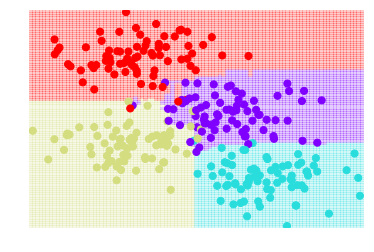

In [28]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=0, criterion='entropy')
visualize_tree(clf, X, y, boundaries=False);
print("average over 100 trees")

## Example 2: Redshift estimation

That is a regression problem not classification (we fit a parameter z and do not sort into a few classes), but the book gives it because it illustrates very well how random forests improve on decision trees.

We use the rms error of the real z to determine if our classification was successful.

We take the colors u-g, g-r and i-z from 60 000 Quasars to create a model that predicts the redshift z of quasars given those colors. 


@pickle_results: using precomputed results from 'photoz_forest.pkl'


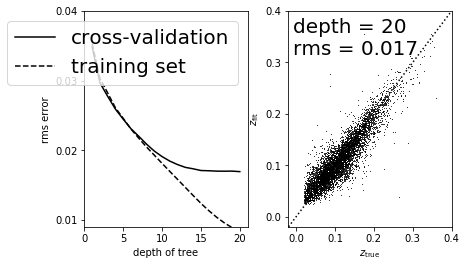

In [35]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from astroML.datasets import fetch_sdss_specgals
from astroML.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Fetch and prepare the data
data = fetch_sdss_specgals()

# put magnitudes in a matrix
mag = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T
z = data['z']

# train on ~60,000 points
mag_train = mag[::10]
z_train = z[::10]

# test on ~6,000 distinct points
mag_test = mag[1::100]
z_test = z[1::100]


#------------------------------------------------------------
# Compute the results
#  This is a long computation, so we'll save the results to a pickle.
@pickle_results('photoz_forest.pkl')
def compute_photoz_forest(depth):
    rms_test = np.zeros(len(depth))
    rms_train = np.zeros(len(depth))
    i_best = 0
    z_fit_best = None

    for i, d in enumerate(depth):
        clf = RandomForestRegressor(n_estimators=10,
                                    max_depth=d, random_state=0)
        clf.fit(mag_train, z_train)

        z_fit_train = clf.predict(mag_train)
        z_fit = clf.predict(mag_test)
        rms_train[i] = np.mean(np.sqrt((z_fit_train - z_train) ** 2))
        rms_test[i] = np.mean(np.sqrt((z_fit - z_test) ** 2))

        if rms_test[i] <= rms_test[i_best]:
            i_best = i
            z_fit_best = z_fit

    return rms_test, rms_train, i_best, z_fit_best


depth = np.arange(1, 21)
rms_test, rms_train, i_best, z_fit_best = compute_photoz_forest(depth)
best_depth = depth[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure()
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# left panel: plot cross-validation results
ax = fig.add_subplot(121)
ax.plot(depth, rms_test, '-k', label='cross-validation')
ax.plot(depth, rms_train, '--k', label='training set')
ax.legend(loc=1, fontsize=20)

ax.set_xlabel('depth of tree')
ax.set_ylabel('rms error')

ax.set_xlim(0, 21)
ax.set_ylim(0.009,  0.04)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

# right panel: plot best fit
ax = fig.add_subplot(122)
ax.scatter(z_test, z_fit_best, s=1, lw=0, c='k')
ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.03, 0.97, "depth = %i\nrms = %.3f" % (best_depth, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes, fontsize=20)

ax.set_xlabel(r'$z_{\rm true}$')
ax.set_ylabel(r'$z_{\rm fit}$')

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

plt.show()

for comparison a simple classification tree:
![red_shift_decision_tree.png](images/red_shift_decision_tree.png)

We see here the training set rms decreases as fast, but from the cross validation we see that we are actually just overfitting. The Random Forest approach just does not break down for high depths, in the contrary it becomes even better for depth =20

In general, this works very well as you can see. These estimations used to be done with masks and were very time consuming, but not necessarily more precise. It is not as accurate as with spectra, but it gives you a first estimate that is already not too far of. This is essential if you get more and more data points #LSST

further reading: boosting classification


## So when should i use those Algorithms?

in practice astronomers try out different algs on their data and see what works best. 

a few general remarks: 
- SVM, Trees and Random Trees assume no underlying distribution for the data points
- LinearSVM are very fast, the implementation in sklearn runs in linear time and still does a pretty good job
- Especially for trees it is a very good idea to do dimensionality reduction first, the tree alg will get faster and it also works better because the axis contains more information and also represent correlations between the original axis.

Scalability:

- Decision trees are relatively efficient, requiring O(N log N) time to build and O(log N) time to classify. For Random Forests we get the same just multiplied by the number of trees
- Random Forests can easily be parallelized!
- Trees and forests need a lot of storage space
- Kernelized SVM have a worst case running time of O(n^3) and have so far resisted efforts to find very fast algs

![summary_classification_algs.png](images/summary_classification_algs.png)